In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
import numpy as np






Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
x_test.shape

(10000, 32, 32, 3)

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [0]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
#Encoder model
input_img = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [0]:
#Decoder model
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=1000,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
                )

In [0]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 16)        9232      
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 16)          0   

In [0]:
#saving model to disk

model_json = autoencoder.to_json()

with open('model_json', 'w') as json_file:
  json_file.write(model_json)
autoencoder.save_weights("model.h5")
print("Saved model to disk..")

Saved model to disk..


In [0]:
#loading model from json
from keras.models import model_from_json

json_file = open('model_json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('model.h5')
print("Loaded model from disk")

FileNotFoundError: ignored

In [0]:
decoded_imgs = loaded_model.predict(x_test)

# New Section

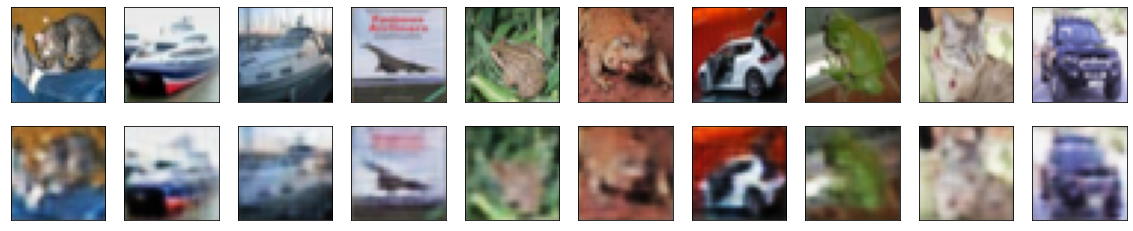

In [0]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [0]:
#Image denoising using autoencoder

#adding noise to the cifar-10 train and test data
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


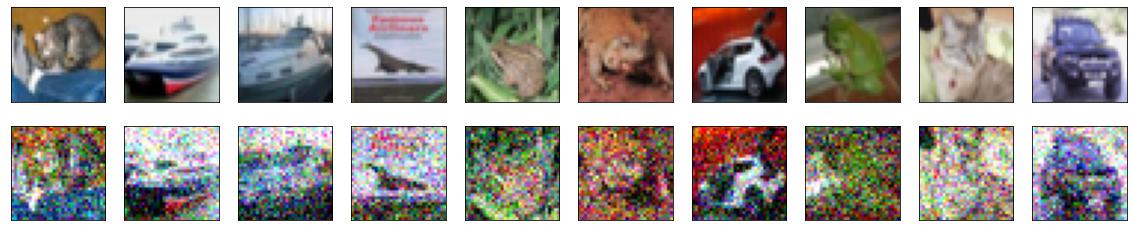

In [0]:
#displaying noisy images using imshow()
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
from keras.callbacks import TensorBoard
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 25s 497us/step - loss: 0.5838 - val_loss: 0.6160
Epoch 2/100
50000/50000 [==============================] - 25s 491us/step - loss: 0.5681 - val_loss: 0.5676
Epoch 3/100
50000/50000 [==============================] - 25s 492us/step - loss: 0.5655 - val_loss: 0.5669
Epoch 4/100
50000/50000 [==============================] - 25s 491us/step - loss: 0.5643 - val_loss: 0.5649
Epoch 5/100
50000/50000 [==============================] - 25s 491us/step - loss: 0.5636 - val_loss: 0.5639
Epoch 6/100
50000/50000 [==============================] - 25s 490us/step - loss: 0.5631 - val_loss: 0.5638
Epoch 7/100
50000/50000 [==============================] - 25s 490us/step - loss: 0.5626 - val_loss: 0.5630
Epoch 8/100
50000/50000 [==============================] - 25s 490us/step - loss: 0.5622 - val_loss: 0.5624
Epoch 9/100
50000/50000 [==============================] - 25s 491us/step - loss: 0.56

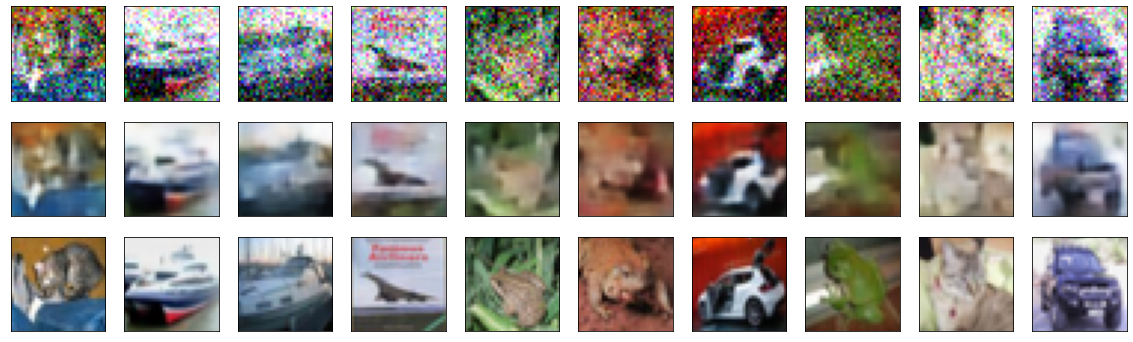

In [0]:
# decoded_imgs_noisy = autoencoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display noisey image
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i+1 + n)
    plt.imshow(decoded_imgs_noisy[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display original image
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

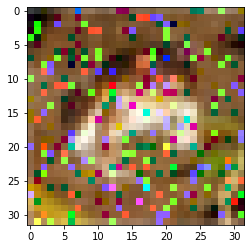

In [0]:
import cv2
import numpy as np
from skimage.util import random_noise

# Load the image
img = cv2.imread("D:/downloads/opencv_logo.PNG")

# Add salt-and-pepper noise to the image.
x_train_sp = random_noise(x_train, mode='s&p',amount=0.1)
x_test_sp = random_noise(x_test, mode='s&p',amount=0.1)

# The above function returns a floating-point image
# on the range [0, 1], thus we changed it to 'uint8'
# and from [0,255]
x_train_sp = np.clip(x_train_sp, 0., 1.)
x_test_sp = np.clip(x_test_sp, 0., 1.)

plt.imshow(x_train_sp[0])


In [0]:
from keras.callbacks import TensorBoard
autoencoder.fit(x_train_sp, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_sp, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 25s 500us/step - loss: 0.5586 - val_loss: 0.5596
Epoch 2/100
50000/50000 [==============================] - 25s 494us/step - loss: 0.5574 - val_loss: 0.5581
Epoch 3/100
50000/50000 [==============================] - 25s 496us/step - loss: 0.5564 - val_loss: 0.5565
Epoch 4/100
50000/50000 [==============================] - 25s 495us/step - loss: 0.5559 - val_loss: 0.5570
Epoch 5/100
50000/50000 [==============================] - 25s 494us/step - loss: 0.5557 - val_loss: 0.5563
Epoch 6/100
50000/50000 [==============================] - 24s 485us/step - loss: 0.5555 - val_loss: 0.5559
Epoch 7/100
50000/50000 [==============================] - 24s 486us/step - loss: 0.5554 - val_loss: 0.5559
Epoch 8/100
50000/50000 [==============================] - 24s 488us/step - loss: 0.5553 - val_loss: 0.5556
Epoch 9/100
50000/50000 [==============================] - 24s 487us/step - loss: 0.55

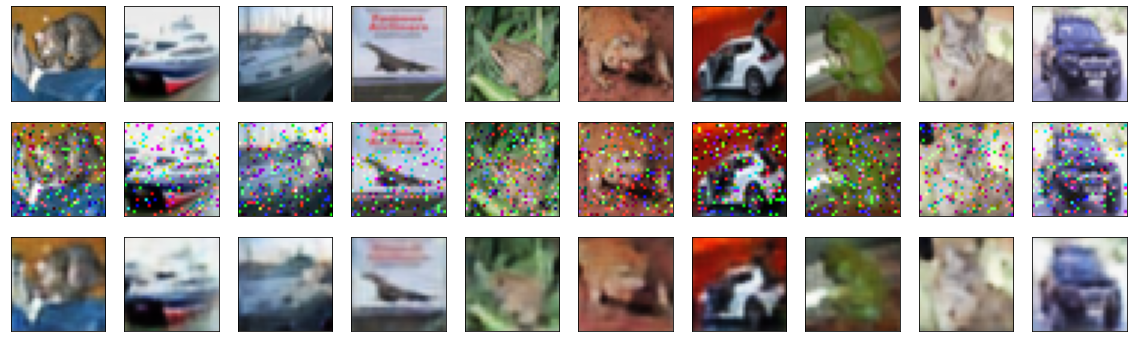

In [0]:
decoded_imgs_noisy_sp = autoencoder.predict(x_test_sp)
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display noisey image
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i+1 + n)
    plt.imshow(x_test_sp[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display original image
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(decoded_imgs_noisy_sp[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()